<a href="https://colab.research.google.com/github/nguyenvuong1309/Learn-machine-learning/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#https://www.youtube.com/watch?v=nVhau51w6dM



import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
ds, ds_info = tfds.load('food101',shuffle_files=True,as_supervised=True,with_info=True)

In [3]:
train_ds,valid_ds = ds['train'],ds['validation']

In [4]:
print(train_ds)
print(valid_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


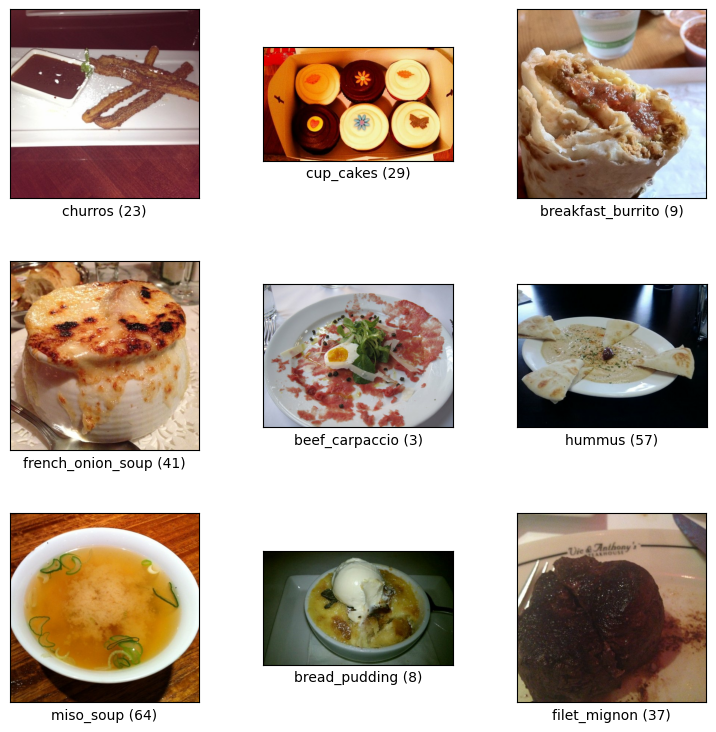

In [5]:
fig = tfds.show_examples(train_ds,ds_info)

In [6]:
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image,[MAX_SIDE_LEN,MAX_SIDE_LEN]),dtype=tf.int32),
                          tf.cast(label == HOT_DOG_CLASS,tf.int32))
)

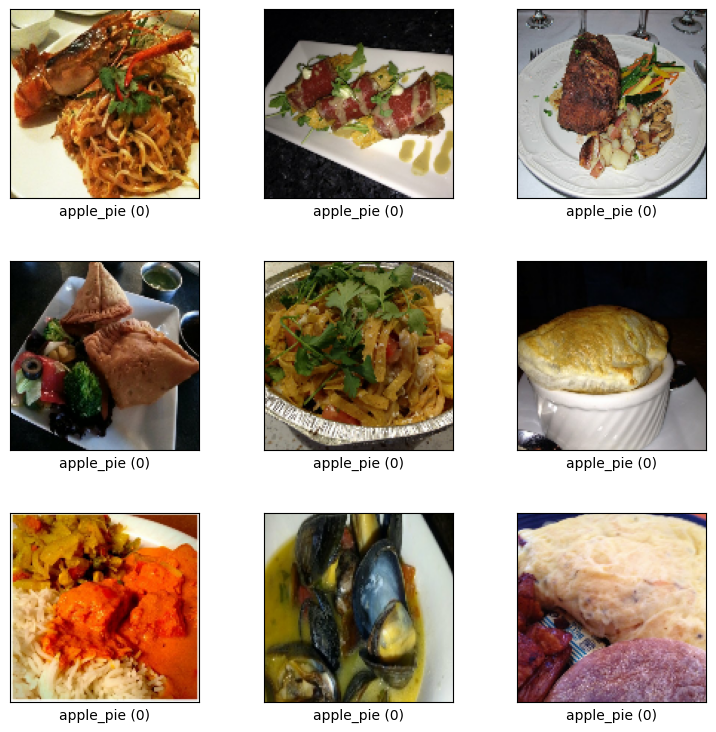

In [7]:
fig = tfds.show_examples(train_ds,ds_info)

In [8]:
train_hd_size, valid_hd_size = 750, 250
train_hotdogs = train_ds.filter(lambda image, label : label == 1).repeat(3)
train_nothotdogs = train_ds.filter(lambda image, label : label == 0)

In [9]:
valid_hotdogs    = valid_ds.filter(lambda image, label : label == 1).repeat(3)
valid_nothotdogs = valid_ds.filter(lambda image, label : label == 0)

In [10]:
batch_size = 16
train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs, train_nothotdogs],
                                                [0.5,0.5],
                                                stop_on_empty_dataset=True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_nothotdogs],
                                                [0.5,0.5],
                                                stop_on_empty_dataset=True)
valid_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [11]:
for image_batch, label_batch in train_ds.take(1):
  print(image_batch)
  print(label_batch)

tf.Tensor(
[[[[136  91  60]
   [143  98  68]
   [149 104  74]
   ...
   [124  46   2]
   [129  47   1]
   [134  49   3]]

  [[139  92  59]
   [137  90  55]
   [136  90  50]
   ...
   [125  44   3]
   [130  49   5]
   [131  49   3]]

  [[143  92  53]
   [141  90  50]
   [136  86  42]
   ...
   [123  40   2]
   [127  44   3]
   [129  45   3]]

  ...

  [[155  70  73]
   [167 116 142]
   [181 176 220]
   ...
   [243 248 244]
   [242 246 244]
   [244 248 247]]

  [[145  51  47]
   [151  99 121]
   [125  92 129]
   ...
   [242 247 242]
   [243 247 244]
   [244 249 246]]

  [[129  30  14]
   [137  60  69]
   [129  55  80]
   ...
   [243 248 240]
   [243 248 240]
   [242 247 241]]]


 [[[130 111 107]
   [136 119 115]
   [138 126 122]
   ...
   [  9   4   1]
   [  8   3   0]
   [  8   3   0]]

  [[139 121 117]
   [142 126 123]
   [143 129 126]
   ...
   [  9   4   1]
   [  8   3   0]
   [  7   2   0]]

  [[145 130 127]
   [143 128 125]
   [147 131 131]
   ...
   [  8   3   0]
   [  8   3   0]


# Neural Net Implementation

In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

In [13]:
for i,_ in ds["train"].take(1):
  image = i


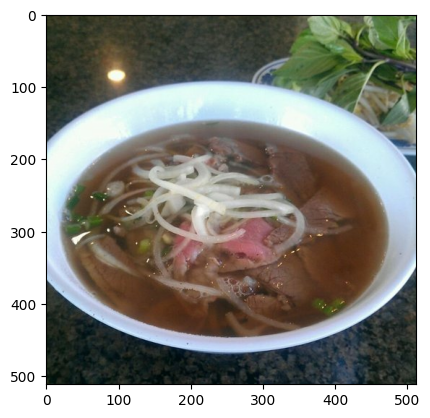

In [14]:
plt.imshow(image)

In [15]:
image = tf.cast(tf.expand_dims(image,0),tf.float32)
image /= 255.0

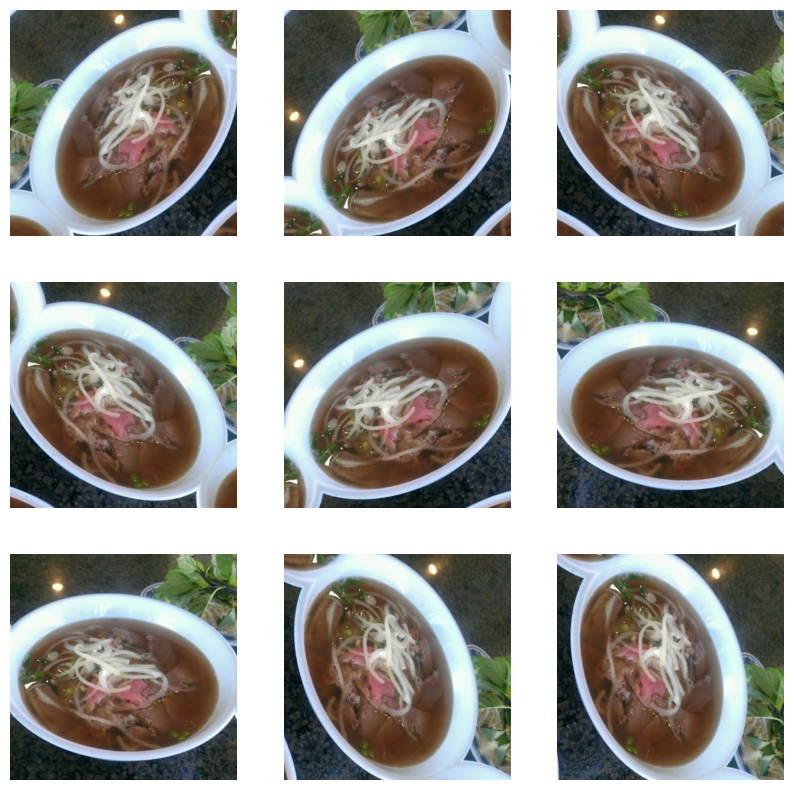

In [16]:
plt.figure(figsize=(10,10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3,3,i+1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [20]:
tf.random.set_seed(0)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Rescaling(1./255))
model.add(data_augmentation)
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation= 'relu', input_shape=[MAX_SIDE_LEN,MAX_SIDE_LEN,3]))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation= 'relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))  # tf.keras.regularizers.l2 mean that create bigger penalty with more change
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation= 'relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1))

In [21]:
lr = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
# from_logits is similar to sigmoid function at last node, from_logits will project output to 0 or 1

In [22]:
epochs = 1
history = model.fit(
    train_ds,
    validation_data = valid_ds,
    epochs = epochs,
    verbose=1
)

    279/Unknown - 638s 2s/step - loss: 1.4551 - accuracy: 0.4991

ValueError: ignored

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in valid_ds.take(1):
  images = image_batch
  labels = label_batch

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3,3,i+1)
  plt.imshow(images[i])
  plt.axis("off")